# Predicting Antigenic Outliers by Cluster using an Isolation Forest

Isolation forests are a method of finding outliers in a dataset using data partitioning. The method works by repetitively partitioning a random feature (of an n-dimensional dataset) between its minimum and maximum values until a sample is isolated or all samples in a partition have the same value. Samples that are higher up in the isolation forst tree are considered outliers where samples deeper in the tree data structure are less likely to be outliers. 

You can read more on the [wikipedia](https://en.wikipedia.org/wiki/Isolation_forest) or the documentation by [sci-kit learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)

This document details the process of predicting outliers (antigenically distinct sequences) when a new antigenic cluster of data is 'seen'.  

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [ ]:
# Some functions for plotting 

# Only get the first of each handle when plotting
def unique_everseen(seq, key=None):
    seen = set()
    seen_add = seen.add
    return [x for x,k in zip(seq,key) if not (k in seen or seen_add(k))]

#  Returns tuple of handles, labels for axis ax, after reordering them to conform to the label order `order`, and if unique is True, after removing entries with duplicate labels.
def reorder_legend_topright(ax=None,order=None,unique=False):
    if ax is None: ax=plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0])) # sort both labels and handles by labels
    if order is not None: # Sort according to a given list (not necessarily complete)
        keys=dict(zip(order,range(len(order))))
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t,keys=keys: keys.get(t[0],np.inf)))
    if unique:  labels, handles= zip(*unique_everseen(zip(labels,handles), key = labels)) # Keep only the first of each handle
    ax.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.25,1))
    return(handles, labels)

# Same as above but for larger plots and to put the legends in the middle
def reorder_legend_middle(ax=None,order=None,unique=False):
    if ax is None: ax=plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0])) # sort both labels and handles by labels
    if order is not None: # Sort according to a given list (not necessarily complete)
        keys=dict(zip(order,range(len(order))))
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t, keys=keys: keys.get(t[0], np.inf)))
    if unique:  labels, handles= zip(*unique_everseen(zip(labels,handles), key = labels)) # Keep only the first of each handle
    ax.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.5,2.25))
    return(handles, labels)

def get_axis_limits(ax, scale=.9):
    return ax.get_xlim()[1]*scale, ax.get_ylim()[1]*scale

In [3]:
CLUSTERS_TO_PRED=['VI75', 'TX77', 'BK79', 
                  'SI87', 'BE89', 'BE92', 
                  'WU95', 'SY97', 'FU02']

CLUSTER_COLORS={'HK68':'dodgerblue',
                'EN72':'magenta',
                'VI75':'olive', 
                'TX77':'aqua', 
                'BK79':'red', 
                'SI87':'gold', 
                'BE89':'grey',
                'BE92':'salmon', 
                'WU95':'teal', 
                'SY97':'maroon', 
                'FU02':'palegreen'}

FEATURES=['distRoot', 'branch_length', 'hydrophobicity', 'charge', 'boman', 'instability', 'isoelectric_point']

In [4]:
# Load data
file_path='../../data/processedData/sequence_physioproperties.csv'
physio_data=pd.read_csv(file_path)

# Get numerical features and scale them to zero mean and unit variance
ss=StandardScaler()
to_scale=physio_data[FEATURES]
scaled_df=pd.DataFrame(ss.fit_transform(to_scale), 
                       columns=to_scale.columns)

# Add the categorical variable back in
scaled_df['cluster'] = physio_data['cluster']
physio_data = scaled_df

## Initial Data

We want to detect outliers (antigenically distinct sequences) as time goes on. We, however, need to start with an initial, small amount of data to train our algorithm. The initial set of data will be the first two antigenic clusters identified by Smith et al. 2004.  

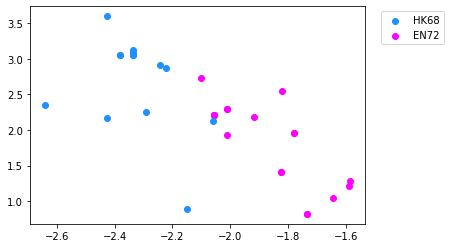

In [5]:
# Get the first two clusters of data ('HK68' and 'EN72')
initial_data=physio_data[physio_data['cluster'] == 'HK68']
initial_data=initial_data.append(physio_data[physio_data['cluster'] == 'EN72'])
current_clusters=initial_data.groupby('cluster')

# Plot distance from the root and hydrophobicity
fig, ax = plt.subplots()
for name, group in current_clusters:
    ax.scatter(x=group['distRoot'], 
               y=group['hydrophobicity'],
               c=CLUSTER_COLORS.get(name),
               label=name)
ax.legend(loc='upper right')
reorder_legend_topright(ax, CLUSTER_COLORS.keys())
plt.show()


## Predictions by Cluster

Predicting outliers while adding antigenic clusters (those following the initial two from above) in loop. Here, I am using all features available (physiochemical and phylogenetic).


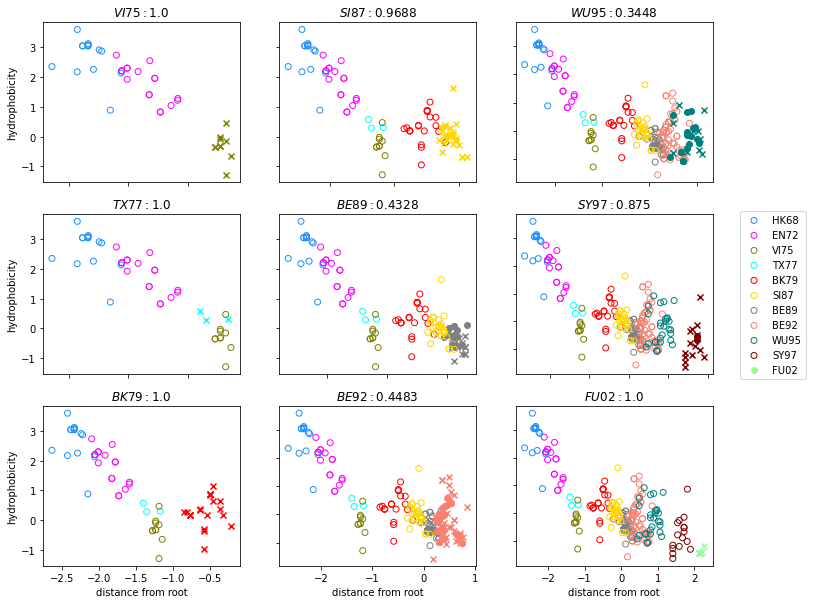

In [6]:
# Set current_data to first two clusters of sequences
current_data=initial_data

fig, axs=plt.subplots(3, 3, figsize=(12,10))

all_features_results=[]

SHAPE = {1: 'o',
         -1: 'x'}

plt_row=0
plt_col=0

for c in CLUSTERS_TO_PRED:    
    # Get next cluster of samples
    next_data=physio_data[physio_data['cluster'] == c]
    n_test=next_data.shape[0]
    
    # Train model
    clf=IsolationForest(random_state=0)
    clf.fit(current_data[FEATURES])

    # Predicting whether the next set of data are outliers
    y_pred=clf.predict(next_data[FEATURES])
    
    # Add number of true positives divided by total "outliers" for current cluster to results
    all_features_results.append(list(y_pred).count(-1)/n_test)
    pred_shape=[SHAPE.get(x) for x in list(y_pred)]
    
    # Append next_data to current_data
    current_data=current_data.append(next_data)
    current_clusters=current_data.groupby('cluster')
    
    # Plot distance from the root and hydrophobicity
    for name, group in current_clusters:
        if (name != c):
            axs[plt_row, plt_col].scatter(x=group['distRoot'], 
                                          y=group['hydrophobicity'],
                                          label=name,
                                          facecolors='none',
                                          edgecolors=CLUSTER_COLORS.get(name))
        else:
            group['marker'] = pred_shape
            not_outliers=group.loc[group['marker'] == 'o']
            outliers=group.loc[group['marker'] == 'x']
            axs[plt_row, plt_col].scatter(x=outliers['distRoot'], 
                                          y=outliers['hydrophobicity'],
                                          c=CLUSTER_COLORS.get(name),
                                          label=None,
                                          marker='x')
            if (not_outliers.shape != (0,)):
                axs[plt_row, plt_col].scatter(x=not_outliers['distRoot'], 
                                              y=not_outliers['hydrophobicity'],
                                              c=CLUSTER_COLORS.get(name),
                                              label=name,
                                              marker='o')

    axs[plt_row, plt_col].set_title(f"${c}:  ${list(y_pred).count(-1)/n_test:.4}")
            
    if plt_row == 2 and plt_col == 2:
        axs[plt_row, plt_col].legend()
        reorder_legend_middle(axs[plt_row, plt_col], CLUSTER_COLORS.keys())
    if plt_row < 2:
        plt_row+=1
    else:
        plt_row=0
        plt_col+=1
    

for ax in axs.flat:
    ax.set(xlabel='distance from root', ylabel='hydrophobicity')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

all_features_avg = sum(all_features_results)/len(CLUSTERS_TO_PRED)

In [7]:
all_features_avg

0.7855210299079316

## Backwards and Forwards Model Selection

Now we would like to know which of the predictive variables provides the most predictive power.

### Backward Elimination

The first step (backwards elimination) will be to start with all features and remove each one and evaluate model performance. Backwards elimination is traditionally done by starting with all predictive variables and removing those which result in the most statistically insignificant deterioration of model fit. I am doing something a bit different. I am going to remove each of the variables from the set of all variables and evaluate which removal results in the most deterioration of model performance.

### Forward Model Selection

After I have ranked which features have the most significant deterioration of model performance, I will add them sequentially by rank of most informative to an empty set of features and evaluate model performance.

In [8]:
backwards_df = {x: [] for x in FEATURES}
backwards_features = FEATURES

n_features = len(FEATURES)

for f in range(0, n_features):
    # Set current_data to first two clusters of sequences
    current_data=initial_data
    
    rm=backwards_features[0]
    del backwards_features[0]
    
    for c in CLUSTERS_TO_PRED:
        # Get next cluster for prediction
        next_data=physio_data[physio_data['cluster'] == c]
        n_test=next_data.shape[0]
        
        # Training the model
        clf=IsolationForest(random_state=0)
        clf.fit(current_data[backwards_features])

        # Predicting whether the next set of data are outliers
        y_pred=clf.predict(next_data[backwards_features])
        backwards_df[rm].append(list(y_pred).count(-1)/n_test)
        
        # Append next_data to current_data
        current_data=current_data.append(next_data)
    
    backwards_features.append(rm)

In [9]:
# Change in average true positives after removing a given feature
results_df=pd.DataFrame(backwards_df)
print(f'The average true positives when all features are used: {all_features_avg}\n')
print('Results when each given feature is not used:')
results_df.mean()  

The average true positives when all features are used: 0.7855210299079316

Results when each given feature is not used:


distRoot             0.730115
branch_length        0.791627
hydrophobicity       0.761616
charge               0.758018
boman                0.760903
instability          0.857476
isoelectric_point    0.838744
dtype: float64

In [10]:
# Get features ranked by the change seen when eliminated
ranked_features=list(results_df.mean().sort_values(ascending=True).to_dict().keys())

# Dictionary with to hold results. Will be converted to pd.DataFrame
forwards_results={x: [] for x in ranked_features}

# Start with an empty set of features
forwards_features=[]

n_features = len(FEATURES)
for i in range(0, n_features):
    # Set current_data to first two clusters of sequences
    current_data=initial_data
    forwards_features.append(ranked_features[i])
    
    for c in CLUSTERS_TO_PRED:    
        # Get next cluster of samples
        next_data=physio_data[physio_data['cluster'] == c]
        n_test=next_data.shape[0]

        # Train model
        clf=IsolationForest(random_state=0)
        clf.fit(current_data[forwards_features])

        # Predicting whether the next set of data are outliers
        y_pred=clf.predict(next_data[forwards_features])

        # Add number of true positives divided by total "outliers" for current cluster to results
        forwards_results[ranked_features[i]].append(list(y_pred).count(-1)/n_test)
        pred_shape=[SHAPE.get(x) for x in list(y_pred)]

        # Append next_data to current_data
        current_data=current_data.append(next_data)


In [11]:
# The average accuracy after removing a given feature
forwards_df=pd.DataFrame(forwards_results)
print(forwards_df.mean())
forwards_df

distRoot             0.994510
charge               0.983531
boman                0.933297
hydrophobicity       0.849813
branch_length        0.859303
isoelectric_point    0.768741
instability          0.813056
dtype: float64


,distRoot,charge,boman,hydrophobicity,branch_length,isoelectric_point,instability
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,1.000000,1.000000,1.000000,1.000000,1.000000,0.968750,0.968750
4,0.985075,0.955224,0.910448,0.835821,0.910448,0.447761,0.835821
5,1.000000,1.000000,0.724138,0.620690,0.568966,0.344828,0.396552
6,0.965517,0.896552,0.827586,0.379310,0.379310,0.344828,0.241379
7,1.000000,1.000000,0.937500,0.812500,0.875000,0.812500,0.875000
8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Removing Features From Phylogenetic Measurements

Measurements from a phylogeny may change over time as additional sequences are added to the phylogeny. We have tested just how much a measurement may change with additional samples being added and we found that most measurements do not change but there are some that do change. 

How can we avoid this? One way we can avoid this is by just not including measurements generated from the phylogeny. The following block of code does just this.

Distance from the root does seem to contain a lot of informational value but it appears the measurement is just recapitulating collection date.

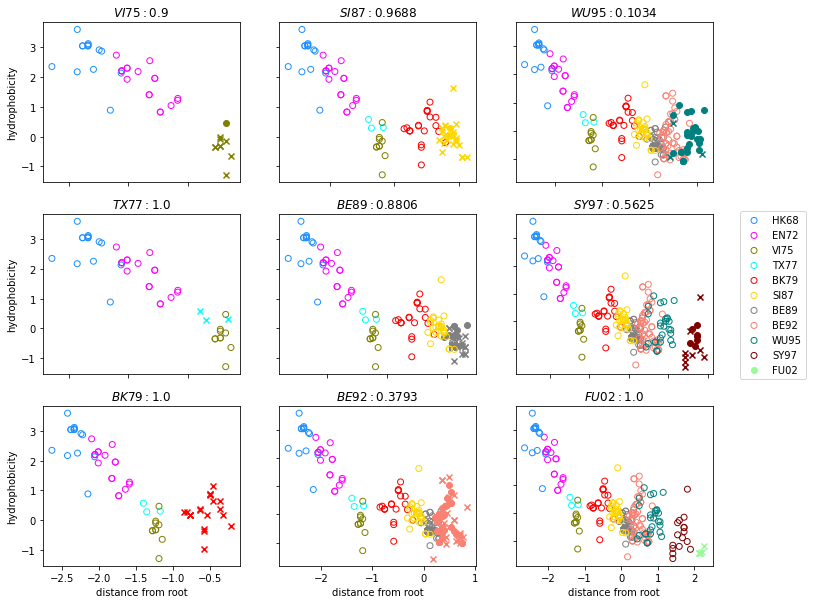

In [13]:
NO_PHYLO_FEATURES=['hydrophobicity', 'charge', 'boman', 'instability', 'isoelectric_point']

# Set current_data to first two clusters of sequences
current_data=initial_data

fig, axs = plt.subplots(3, 3, figsize=(12,10))

SHAPE = {1: 'o',
         -1: 'x'}

nophylo_features_results = []

plt_row=0
plt_col = 0

for c in CLUSTERS_TO_PRED:    
    next_data=physio_data[physio_data['cluster'] == c]
    n_test=next_data.shape[0]
    # Training the model
    clf=IsolationForest(random_state=0)
    clf.fit(current_data[NO_PHYLO_FEATURES])

    # Predicting whether the next set of data are outliers
    y_pred=clf.predict(next_data[NO_PHYLO_FEATURES])
    nophylo_features_results.append(list(y_pred).count(-1)/n_test)
    pred_shape=[SHAPE.get(x) for x in list(y_pred)]
    # Append next_data to current_data
    current_data=current_data.append(next_data)
    current_clusters=current_data.groupby('cluster')
    # Plot distance from the root and hydrophobicity
    #print(y_pred)
    for name, group in current_clusters:
        if (name != c):
            axs[plt_row, plt_col].scatter(x=group['distRoot'], 
                                          y=group['hydrophobicity'],
                                          label=name,
                                          facecolors='none',
                                          edgecolors=CLUSTER_COLORS.get(name))
        else:
            group['marker'] = pred_shape
            not_outliers=group.loc[group['marker'] == 'o']
            outliers=group.loc[group['marker'] == 'x']
            axs[plt_row, plt_col].scatter(x=outliers['distRoot'], 
                                          y=outliers['hydrophobicity'],
                                          c=CLUSTER_COLORS.get(name),
                                          label=None,
                                          marker='x')
            if (not_outliers.shape != (0,)):
                axs[plt_row, plt_col].scatter(x=not_outliers['distRoot'], 
                                              y=not_outliers['hydrophobicity'],
                                              c=CLUSTER_COLORS.get(name),
                                              label=name,
                                              marker='o')

    axs[plt_row, plt_col].set_title(f"${c}:  ${list(y_pred).count(-1)/n_test:.4}")
            
    if plt_row == 2 and plt_col == 2:
        axs[plt_row, plt_col].legend()
        reorder_legend_middle(axs[plt_row, plt_col], CLUSTER_COLORS.keys())
    if plt_row < 2:
        plt_row+=1
    else:
        plt_row=0
        plt_col+=1
    

for ax in axs.flat:
    ax.set(xlabel='distance from root', ylabel='hydrophobicity')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

nophylo_features_avg=sum(nophylo_features_results)/len(CLUSTERS_TO_PRED)

In [14]:
nophylo_features_avg

0.7549561817350032

## Addressing data leakage and achieving a better understanding our results

A number of people highlighted that I was not splitting my training and testing data for downstream validation of the model. Another issue that has been brought up is that the above results only really show us the percentage of true positives (and, in a way, the false negatives). 

The code below is an effort to address these issues. I am doing a training/testing split of 80/20 and the results are evaluated to provide both true and false negatives and positives. 

In [37]:
# Set current_data to first two clusters of sequences
current_data=initial_data

# split the initial dataset to get 20% testing
X_train, X_test, y_train, y_test = train_test_split(current_data[NO_PHYLO_FEATURES], 
                                                    current_data['cluster'], 
                                                    test_size=0.2, 
                                                    random_state=0)

SHAPE = {1: 'o', -1: 'x'}

nophylo_features_results = []

plt_row=0
plt_col=0

for c in CLUSTERS_TO_PRED:
    # Training the model
    clf=IsolationForest(random_state=0).fit(X_train)
    
    #### I need to save the model and the test subset here 

    # Predicting whether the next set of data are outliers
    # Get the data points in next cluster
    next_data=physio_data[physio_data['cluster'] == c]
    Next_X_train, Next_X_test, next_y_train, next_y_test = train_test_split(next_data[NO_PHYLO_FEATURES],
                                                                            next_data['cluster'],
                                                                            test_size=0.2,
                                                                            random_state=0)
    # Get number of predictions 
    n_pred=Next_X_train.shape[0]
    # Make predictions
    y_pred=clf.predict(Next_X_train)
    nophylo_features_results.append(list(y_pred).count(-1)/n_test)
    # Print the cluster
    print(f'Cluster: {c}; {n_pred} predictions were made with {list(y_pred).count(-1)/n_pred} being correct \n')

    # Append Next_X_train to X_train
    X_train=X_train.append(Next_X_train)
    X_test=X_test.append(Next_X_test)
    y_train=y_train.append(next_y_train)
    y_test=y_test.append(next_y_test)

    # Now I want to make predictions on a combination of data points from previous clusters and the next cluster
    y_pred=clf.predict(X_test)

    # y_pred will now be a list of 1s and -1s and I need to see which are 'correct' and which are 'incorrect' 
    #   using y_test
    
    # true_positive - outliers that are truly outliers
    true_positive=0
    # true_negative - normals that are truly normies
    true_negative=0
    # false_positive - outliers that are not outliers
    false_positive=0
    # false_negative - normies that are actually outliers
    false_negative=0
    for i in range(0, len(y_pred)):
        if list(y_test)[i] == c and y_pred[i] == -1:
            true_positive += 1
        elif list(y_test)[i] == c and y_pred[i] == 1:
            false_negative += 1
        elif list(y_test)[i] != c and y_pred[i] == -1:
            false_positive += 1
        elif list(y_test)[i] != c and y_pred[i] == 1:
            true_negative += 1
        print(f'{list(y_test)[i]}: {y_pred[i]}')
    print('\n')

    print(f'True positive: {true_positive/list(y_test).count(c)}')
    print(f'True negative: {true_negative/(len(list(y_test)) - list(y_test).count(c))}')
    print(f'False positive: {false_positive/list(y_test).count(c)}')
    print(f'False negative: {false_negative/(len(list(y_test)) - list(y_test).count(c))}')

    print('\n')
    #print(f'Cluster: {c}; {n_pred} predictions were made with {list(y_pred).count(-1)/n_pred} being correct')
    



Cluster: VI75; 8 predictions were made with 1.0 being correct 

HK68: -1
EN72: 1
HK68: 1
HK68: -1
EN72: 1
EN72: 1
EN72: 1
VI75: -1
VI75: 1


True positive: 0.5
True negative: 0.7142857142857143
False positive: 1.0
False negative: 0.14285714285714285


Cluster: TX77; 2 predictions were made with 1.0 being correct 

HK68: -1
EN72: 1
HK68: 1
HK68: -1
EN72: 1
EN72: 1
EN72: 1
VI75: 1
VI75: 1
TX77: -1


True positive: 1.0
True negative: 0.7777777777777778
False positive: 2.0
False negative: 0.0


Cluster: BK79; 16 predictions were made with 1.0 being correct 

HK68: -1
EN72: 1
HK68: 1
HK68: -1
EN72: 1
EN72: 1
EN72: 1
VI75: 1
VI75: 1
TX77: -1
BK79: -1
BK79: -1
BK79: -1
BK79: -1


True positive: 1.0
True negative: 0.7
False positive: 0.75
False negative: 0.0


Cluster: SI87; 25 predictions were made with 0.96 being correct 

HK68: -1
EN72: 1
HK68: 1
HK68: -1
EN72: 1
EN72: 1
EN72: 1
VI75: 1
VI75: 1
TX77: 1
BK79: 1
BK79: 1
BK79: -1
BK79: -1
SI87: -1
SI87: -1
SI87: -1
SI87: -1
SI87: -1
SI87: -1
S